In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

%pip install opencv-python
%pip install cmake
%pip install dlib
%pip install face_recognition
%pip install tensorflow
%pip install imgaug


In [ ]:
import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

import seaborn as sns

from sklearn.manifold import TSNE
from skimage.transform import resize
from skimage.feature import hog
from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
import pathlib
from tqdm.notebook import tqdm
import face_recognition as fr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV, LeaveOneGroupOut
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.manifold import TSNE
from skimage.transform import resize
from skimage.feature import hog
from sklearn.cluster import KMeans
from scipy.spatial import distance
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import randint, uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import shutil
import imgaug

from math import ceil
from matplotlib import pyplot as plt # Plotting library
import random
import warnings
warnings.filterwarnings("ignore")

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0922642, r0911432, r0864518, r0768517, r0822921. </span>

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
1. Data loading & Preprocessing
2. Data Cleaning
3. Augmentation
4. Feature Representations
5. Evaluation Metrics
6. Classifiers
7. Experiments
8. Publishing best results
9. Discussion
10. References

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    


# 1.Data loading & Preprocessing



## 1.1 Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [ ]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

## 1.2 Data Augmentation for raw data
Two data augmentation have been made: one is made before data preprocessing to generate raw data, and the other is made after data preprocessing and data cleaning for new high-quality image generate. 

For this part, it is raw image generation before data preprocessing. The motivation and result analysis are below. 

The current dataset comprises only 80 images, a number which is deemed insufficient for achieving optimal results. In order to address this issue, data augmentation techniques have been employed to improve the performance of the model. Eight of the most popular augmentation methods, namely flip, rotation, non-90° rotation, zoom-in/out, random resize, translation, adding Gaussian noise, and light change, have been utilized to generate 80 new images for each of the original images. This process has resulted in a total of 6400 augmented images and 80 original images forming a new pandas dataframe referred to as "train_new". It is worth noting that "train_new" is distinct from "train". The user can switch between the two dataframes in the last "run_all()" cell to achieve different outcomes.

On the one hand, the performance disparity between using raw data augmentation, which yields an accuracy of 75%, and non-use of such augmentation, which produces an accuracy of 35%, is significant. However, the efficacy of raw data augmentation is limited when compared to other more sophisticated techniques, such as data cleaning and the utilization of advanced face recognition methods that boast higher levels of performance. In such cases, the impact of raw data augmentation on the prediction accuracy is often underwhelming, resulting in marginal or negative improvements.

In [ ]:
# raw data augmentation
def flip(img):
    flip_img1 = cv2.flip(img, 1)
    flip_img2 = cv2.flip(img, 0)
    flip_img3 = cv2.flip(img, -1)
    return [flip_img1, flip_img2, flip_img3]
# 90° rotate # 3
def rotate(img):
    rotate_img1 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)       
    rotate_img2 = cv2.rotate(img, cv2.ROTATE_180)
    rotate_img3 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return [rotate_img1, rotate_img2, rotate_img3]
# rotate in non-90° #9
def non_rectan_rotate(img):
    non_rectan_rotate_list = []
    width = img.shape[1]
    height = img.shape[0]
    for angle in range(20,360,40): # 20,60,100,140,180,220,160,300,340
        rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height))
        non_rectan_rotate_list.append(rotated_img)
    # print(len(non_rectan_rotate_list))
    return non_rectan_rotate_list
# zoom-in/out # 8
def zoom(img):
    zoom_list = []
    for i in np.arange(0.5,2,0.2): # 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9
        width = int(img.shape[1] * i)
        height = int(img.shape[0] * i)
        resized_img = cv2.resize(img, (width, height))
        zoom_list.append(resized_img)
    # print(len(zoom_list))    
    return zoom_list
# random resize   # 16
def random_scale(img):
    random_scale_list = []
    for i in np.arange(0.4,2,0.5): # 0.4, 0.9, 1.4, 1.9
        for j in np.arange(0.6,2.2,0.5): # 0.6, 1.1, 1.6, 2.1 
            width = int(img.shape[1] * i)
            height = int(img.shape[0] * j)
            resized_img = cv2.resize(img, (width, height))
            random_scale_list.append(resized_img)
    # print(len(random_scale_list))
    return random_scale_list
# translation # 9
def translation(img):
    translation_list = []
    for x in range(50, 100, 20): #50,70,90
        for y in range(50, 100, 20):
            M = np.float32([[1, 0, x], [0, 1, y]])
            translated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
            translation_list.append(translated_img)
    # print(len(translation_list))
    return translation_list
# add Gaussian noise # 16
def addnoise(img):
    addnoise_list = []
    for mean in range(0,40,10):
        for variance in range(10,50,10):
            sigma = np.sqrt(variance)
            gaussian = np.random.normal(mean, sigma, img.shape).astype('uint8')
            noisy_img = cv2.add(img, gaussian)
            addnoise_list.append(noisy_img)
    # print(len(addnoise_list))
    return addnoise_list
#light change # 16
def light(img):
    light_list = []
    for bright in np.arange(0.5,1.5,0.3): 
        for contrast in np.arange(0.5,1.5,0.3):
            light_img = cv2.convertScaleAbs(img, alpha=contrast, beta=(1-bright)*255)
            light_list.append(light_img)
    # print(len(light_list))
    return light_list
train_new = train.copy(deep=True)
def generate_new_img(train_df):
    for index,row in train.iterrows():
        name = train.loc[index][0]
        classtype = train.loc[index][1]
        img = train.loc[index][2]

        for f in flip(img):
            new_data_f = {'name': name, 'class': classtype, 'img': f}
            train_new.loc[len(train_new)] = new_data_f
        for r in rotate(img):
            new_data_r = {'name': name, 'class': classtype, 'img': r}
            train_new.loc[len(train_new)] = new_data_r
        for nr in non_rectan_rotate(img):
            new_data_nr = {'name': name, 'class': classtype, 'img': nr}
            train_new.loc[len(train_new)] = new_data_nr
        for z in zoom(img):
            new_data_z = {'name': name, 'class': classtype, 'img': z}
            train_new.loc[len(train_new)] = new_data_z
        for rs in random_scale(img):
            new_data_rs = {'name': name, 'class': classtype, 'img': rs}
            train_new.loc[len(train_new)] = new_data_rs
        for tr in translation(img):
            new_data_tr = {'name': name, 'class': classtype, 'img': tr}
            train_new.loc[len(train_new)] = new_data_tr
        for an in addnoise(img):
            new_data_an = {'name': name, 'class': classtype, 'img': an}
            train_new.loc[len(train_new)] = new_data_an
        for l in light(img):
            new_data_l = {'name': name, 'class': classtype, 'img': l}
            train_new.loc[len(train_new)] = new_data_l
    return train_new
train_new = generate_new_img(train)

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 1.3 A first look
The present study analyzes two sets of training datasets: "train" comprising the original dataset with 80 images, and "train_new" containing an augmented dataset with 6480 images. To provide a comprehensive overview of the datasets, the data columns and class distribution are examined.

In [ ]:
print(train)
print(train_new)

### Visualizing the dataset

In [ ]:
# The training set contains an identifier, name, image information and class label
print(train.head(1))
print(train_new.head(1))
# The test set only contains an identifier and corresponding image information.

print(test.head(1))
# The class distribution in the training set:
print(train.groupby('name').agg({'img':'count', 'class': 'max'}))
print(train_new.groupby('name').agg({'img':'count', 'class': 'max'}))

In [ ]:
# parameter to play with 
FACE_SIZE = (100, 100)
def plot_image_sequence(data, n, imgs_per_row=10):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

In [ ]:
train_images = train['img'].to_numpy()
train_new_images = train['img'].to_numpy()
plot_image_sequence(train_images[50:80], n=30)
plot_image_sequence(train_new_images[50:80], n=30)

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

##  1.4 Preprocess data



### 1.4.1 HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>

The dataset contains 80 images of 4 faces, where the original images are full-body photos. The first step is to extract the face images from the full-body photos. The Haar feature classifier is used to detect the facial part in the photos. The cv2.CascadeClassifier() function in OpenCV is used to scan the input images by loading the trained classifier file and determining whether there are target objects. However, the main advantage of the Haar feature classifier is that it can quickly detect faces and work under different lighting and facial expression conditions. However, its recognition performance for occluded and profile faces is not ideal. To enhance the dataset and obtain as much faces as possible, we encapsulated the "faces" parameter in the class to determine whether to perform multiple extractions. By setting the "faces" parameter, we can choose to extract all faces or only one face per image. For the extraction of all faces in each photo, the detectMultiScale method in the CascadeClassifier class is used. This method divides the input image into multiple sub-regions, applies the cascade classifier to each sub-region for target detection, and finally returns the rectangular boundary of the target. The minimum detection rectangle is set to 30*30, and the minimum adjacent pixel is 5 pixels. A total of 97 face images were extracted from 80 images. During the face extraction process, since the size of each face image is not consistent, this may cause inconsistency in the dimension of the subsequent training set. Therefore, the cv2.resize function is used to scale the images to a consistent size, while the area interpolation algorithm is used to ensure the fidelity of the scaled images.

In [ ]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size, faces=-1):
        self.face_size = face_size
        self.faces = faces
        
        # for cases when there are several faces
        if faces == 1:
            self.name = 'HAAR_FIRST'
        else:
            self.name = 'HAAR_MULTI'
            
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            if self.faces == 1:
                return nan_img
            else:
                return np.array([nan_img])
        
        if self.faces == 1:
            return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
        else:
            return np.array([cv2.resize(face, self.face_size, interpolation = cv2.INTER_AREA) for face in faces])
    
    def __call__(self, data, values=None, label='train'):
        data_path = r"./1_Face_Detection/" + self.name
        pathlib.Path(data_path).mkdir(parents=True, exist_ok=True)
        face_array = []
        class_values = []
        ids = []
        for i, row in data.iterrows():
            if self.faces == 1:
                face_array.append(self.preprocess(row))
            else:
                for face in self.preprocess(row):
                    if values is not None:
                        ids.append(i)
                        class_values.append(values[i])
                    face_array.append(face)
        if self.faces == 1 and values is not None:
            ids = list(range(len(values)))
            class_values = values

        X = np.stack(face_array).astype(int)
        y = np.array(class_values)
        ids = np.array(ids)

        np.save(os.path.join(data_path, '{}_X_{}.npy'.format(label, self.name)), X)
        np.save(os.path.join(data_path, '{}_y_{}.npy'.format(label, self.name)), y)
        np.save(os.path.join(data_path, '{}_ids_{}.npy'.format(label, self.name)), ids)
        return X, y, ids

### 1.4.2 Face_Recognition

Face_Recognition([github_link](https://github.com/ageitgey/face_recognition)) package is one of the most famous face detection python toolkits and has a high face recognition rate. In the dataset, some images may have more than one face, we try to use this library to detect all the faces in every image. And in the data cleaning step, we choose the face with the best match to the labe/name.

Therefore, we use the face_locationsh function with Hog mode, which requires only CPU.



In [ ]:
class Face_Recognition_Preprocessor():
    """Preprocessing pipeline built around the face-recognition package built on cmake and dlib. """
    def __init__(self, face_size, model='hog', faces=1):
        self.name = 'FACEREC'
        self.face_size = face_size                                     
        self.model = model
        self.faces = faces

    def detect_faces(self, img):
        """Detects all faces in an image"""        
        return fr.face_locations(img, model=self.model)
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        faces = self.detect_faces(img)

        # return the cropped images
        return [img[top:bottom, left:right] for (top, right, bottom, left) in faces] #top, right, bottom, left
    
    def preprocess(self, data_row):
        """Returns the cropped images resized to prespecified face_size"""
        faces = self.extract_faces(data_row['img']) 
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = 0
            if self.faces == 1:
                return nan_img
            else:
                return np.array([nan_img])
        
        if self.faces == 1:
            return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
        else:
            return np.array([cv2.resize(face, self.face_size, interpolation = cv2.INTER_AREA) for face in faces])

    
    def __call__(self, data, values=None, label='train'):
        # data_path = r"./1_Face_Detection/" + self.name
        # pathlib.Path(data_path).mkdir(parents=True, exist_ok=True)
        # flag_X = pathlib.Path(os.path.join(data_path, '{}_X_{}.npy'.format(label, self.name))).exists()
        # flag_y = pathlib.Path(os.path.join(data_path, '{}_y_{}.npy'.format(label, self.name))).exists()
        # flag_ids = pathlib.Path(os.path.join(data_path, '{}_ids_{}.npy'.format(label, self.name))).exists()
        # if flag_X and flag_y and flag_ids:
        #     print('Data has already exsited!')
        #     X = np.load(os.path.join(data_path, '{}_X_{}.npy'.format(label, self.name)))
        #     y = np.load(os.path.join(data_path, '{}_y_{}.npy'.format(label, self.name)))
        #     ids = np.load(os.path.join(data_path, '{}_ids_{}.npy'.format(label, self.name)))
        # else:
        face_array = []
        class_values = []
        ids = []
        for i, row in data.iterrows():
            if self.faces == 1:
                face_array.append(self.preprocess(row))
            else:
                for face in self.preprocess(row):
                    ids.append(i)
                    
                    if values is not None:
                        class_values.append(values[i])
                    face_array.append(face)
        if self.faces == 1 and values is not None:
            ids = list(range(len(values)))
            class_values = values

        X = np.stack(face_array).astype(int)
        y = np.array(class_values)
        ids = np.array(ids)
            

            # np.save(os.path.join(data_path, '{}_X_{}.npy'.format(label, self.name)), X)
            # np.save(os.path.join(data_path, '{}_y_{}.npy'.format(label, self.name)), y)
            # np.save(os.path.join(data_path, '{}_ids_{}.npy'.format(label, self.name)), ids)
        return X, y, ids

## 1.5 Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [ ]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 2.Data cleaning

Data cleaning is a crucial step as the model performance heavily relies on the quality of the available data. Inaccurate or inconsistent data can lead to overfitting, poor model performance, and inaccurate predictions, especially in the case of a limited dataset. It generally involves identifying and addressing issues such as missing data, outliers, and incorrect labeling(Wang et al., 2004). Based on our observations above, we found 2 main issues in our dataset:

1. multiple faces in one image

2. black images

For the first one, let's try to select the most probable faces using cosine distances between the candidate faces and other images with similar numbers following previous studies(Hu et al., 2020; Zhang et al., 2020; Chen et al., 2020). For the second one, let's try to remove the black images using RGB features.

## 2.1 multiple faces in one image

In [ ]:
class DataCleaning():
    def __init__(self, train_X, train_y, ids, features):
        self.train_X = train_X
        self.train_y = train_y
        self.ids = ids
        self.features = features
        self.data_path = r"./3_Data_Cleaning/"
    
    def cosine_similarity_train(self, rows):
        similarity_train = []        
        for class_feature in self.data[self.data['class'] == rows['class']]['feature'].to_numpy():
            tmp = (distance.cosine(class_feature, rows['feature']) - 1) * (-1)
            similarity_train.append(tmp)
        similarity_train = np.array(similarity_train)
        tmp = np.mean(similarity_train[~np.isnan(similarity_train)]) 
        return 0 if np.isnan(tmp) else tmp
    
    def cosine_similarity_test(self, rows, class_id):
        similarity_test = []        
        for class_feature in self.train_data[self.train_data['class'] == class_id]['feature'].to_numpy():
            tmp = (distance.cosine(class_feature, rows['feature']) - 1) * (-1)
            similarity_test.append(tmp)
        similarity_test = np.array(similarity_test)
#         print('similarity_test',similarity_test)
        return np.mean(similarity_test[~np.isnan(similarity_test)])
    
    def calc_similarity(self):
        if self.train_y is not None:
            self.data['cos_similarity'] = self.data.apply(self.cosine_similarity_train, axis=1) # row
        else:
            self.data['cos_similarity_0'] = self.data.apply(self.cosine_similarity_test, axis=1, args=(0,))
            self.data['cos_similarity_1'] = self.data.apply(self.cosine_similarity_test, axis=1, args=(1,))
            self.data['cos_similarity_2'] = self.data.apply(self.cosine_similarity_test, axis=1, args=(2,))
            self.data['cos_similarity'] = self.data[['cos_similarity_0', 'cos_similarity_1', 'cos_similarity_2']].max(axis=1) #classes:0, 1, 2
        return self.data
    
    
    def delete_dissimilar(self):
        amount = self.data.groupby('id').agg({'id':'count'})
        idx = list(amount[amount['id'] > 1].index)
        for ind in idx:
            if (self.data[self.data['id'] == ind]['cos_similarity'] == 0).all():
                0
            max_similarity = self.data[self.data['id'] == ind]['cos_similarity'].max()
            self.data.drop(self.data[np.logical_and(self.data['id'] == ind, self.data['cos_similarity'] < max_similarity)].index,
                           inplace=True)
        self.data.reset_index(drop=True, inplace=True)
        print('data',self.data)
        return self.data
    
    def get_class(self):
        y = np.load(os.path.join(self.data_path, '{}_{}_{}_y_clean.npy'.format(self.label, self.feature_name,
                                                                                   self.preproc)))
        return y
    
    def load_training(self, train_X, train_y, feature):
        self.train_data = pd.DataFrame({'class': train_y, 'img': list(train_X), 'feature': list(feature)})
        return self.train_data
        
    def cleaning(self, train_X=None, train_y=None, train_features=None,label='train', feature='hog', preproc='HAAR'):
        pathlib.Path(self.data_path).mkdir(parents=True, exist_ok=True)
        self.label = label
        self.feature_name = feature
        self.preproc = preproc
        
        # flag_X = pathlib.Path(os.path.join(self.data_path, '{}_{}_{}_X_clean.npy'.format(self.label, self.feature_name,self.preproc))).exists()
        # if train_y is None:
        #     flag_y = pathlib.Path(os.path.join(self.data_path, '{}_{}_{}_y_clean.npy'.format(self.label, self.feature_name,self.preproc))).exists()
        # else:
        #     flag_y = True
        # if (flag_X and flag_y):
        #     print('Data has already exsited!')
        #     X = np.load(os.path.join(self.data_path, '{}_{}_{}_X_clean.npy'.format(self.label, self.feature_name,
        #                                                                            self.preproc)), allow_pickle=True)
        # else:
        self.data = pd.DataFrame({'id': self.ids})
        if self.train_y is not None:
            self.data['class'] = list(self.train_y)
        self.data['img'] = list(self.train_X)
        self.data['feature'] = list(self.features)
        if train_X is not None and train_y is not None and train_features is not None:
            print(len(train_X), len(train_y), len(train_features))
            self.load_training(train_X, train_y, train_features)
        self.calc_similarity()
        self.delete_dissimilar()
        X = self.data['img'].to_numpy()
        print(X.shape)
        np.save(os.path.join(self.data_path, '{}_{}_{}_X_clean.npy'.format(self.label, self.feature_name,
                                                                            self.preproc)), X)
        if train_y is None:
            y = self.data['class'].to_numpy()            
            np.save(os.path.join(self.data_path, '{}_{}_{}_y_clean.npy'.format(self.label, self.feature_name,
                                                                            self.preproc)), y)
        return X

## 2.2 Remove black images

In [ ]:
def remove_black_images(train_X, train_y):
    indices_to_delete = []
    for i, row in enumerate(train_X):
        if not np.count_nonzero(row):
            if i < train_X.shape[0]:
                indices_to_delete.append(i)
    train_X = np.delete(train_X, indices_to_delete, axis=0)
    train_y = np.delete(train_y, indices_to_delete)
    return train_X, train_y

# 3.Augmentation

Apart from augmenting raw data, we have also generate high-quality new data after feature extraction and data cleaning. 

The benefit of data augmentation after feature extraction and data cleaning, compared to data augmentation before data preprocessing, lies in the quality of the data being augmented. When we augment raw data, we may be adding noise or irrelevant information to the data, which can decrease the performance of the model. In contrast, data augmentation after feature extraction and data cleaning can produce high-quality data that is more relevant and useful for the task at hand.

Another advantage of data augmentation after feature extraction and data cleaning is that it can help to address issues such as class imbalance or data sparsity. By generating new data from existing samples, we can balance the distribution of classes and increase the diversity of the data, which can improve the generalization ability of the model.

In this study, we utilized five distinct data augmentation approaches including flip, autocontrast, GaussianBlur, SaltandPepper, and light change. We conducted a thorough investigation of the effects of the number of augmented images generated on model performance. Our analysis suggests that increasing the number of augmented images beyond a certain threshold does not necessarily yield a commensurate improvement in model performance.

## 3.1 Generate one image through one method
One function generate one new image. 
For example, imgaug.augmenters.GaussianBlur(sigma=0.50) only generate 1 image. In total, there are 7 generated new images for one image.





In [ ]:
class Aug():
    def __init__(self):
        self.flip = imgaug.augmenters.Fliplr(1)
        self.autocontrast = imgaug.augmenters.pillike.Autocontrast()
        self.blur1 = imgaug.augmenters.GaussianBlur(sigma=0.50)
        self.noise = imgaug.augmenters.SaltAndPepper(0.02)
        self.blur2 = imgaug.augmenters.GaussianBlur(sigma=1.5)
        self.lighten = imgaug.augmenters.Multiply(1.5)
        self.darken = imgaug.augmenters.Multiply(0.5)

        
    def augmentation(self, img):
        aug_train_X = []
        aug_train_X.append(np.uint8(img))
        aug_train_X.append(self.flip(image=np.uint8(img)))
        aug_train_X.append(self.autocontrast(image=np.uint8(img)))
        aug_train_X.append(self.blur1(image=np.uint8(img)))
        aug_train_X.append(self.noise(image=np.uint8(img)))
        aug_train_X.append(self.blur2(image=np.uint8(img)))
        aug_train_X.append(self.lighten(image=np.uint8(img)))
        aug_train_X.append(self.darken(image=np.uint8(img)))
        return aug_train_X
    
    def __call__(self, X, y):
        aug_X = []
        aug_y = []
        for i, img in enumerate(X):
            aug_X.extend(self.augmentation(img))
            aug_y.extend([y[i] for _ in range(8)])

        tmp = np.empty(len(aug_X), dtype=object)
        tmp[:] = aug_X
        aug_X = tmp
        return np.array(aug_X), np.array(aug_y)

## 3.2 Generate multiple image through one method
One function generate multiple new image. 
For example, imgaug.augmenters.GaussianBlur(sigma=0.50) only generate 1 image. In total, there are 100 generated new images for one image.


In [ ]:
import imgaug.augmenters as iaa
class Dataaugmentation:

    def __init__(self):
        self.seq = iaa.Sequential([
        iaa.Fliplr(p=0.5),  # flip horizontally with probability 0.5
        iaa.GammaContrast(gamma=(0.5, 2)),  # modify contrast randomly between 0.5 and 1.5
        iaa.GaussianBlur(sigma=(0, 3.0)),  # blur the image randomly with sigma between 0 and 3
        iaa.SaltAndPepper(p=(0, 0.2)),  # add salt and pepper noise randomly with probability between 0 and 0.1
        iaa.GaussianBlur(sigma=(0, 3.0)),  # blur the image randomly with sigma between 0 and 3
        iaa.Multiply((0.5, 1.5))  # adjust brightness randomly between 0.5 and 1.5
    ], random_order=True)

    def generate(self,img):
        img = np.array(img, dtype=np.uint8)
        images_aug = self.seq.augment_images([img]*100)
        
        return images_aug


    def __call__(self, X, y):
        aug_X = []
        aug_y = []
        for i, img in enumerate(X):
            aug_X.extend(self.generate(img))
            aug_y.extend([y[i] for _ in range(100)])

        tmp = np.empty(len(aug_X), dtype=object)
        tmp[:] = aug_X
        aug_X = tmp
        print(np.array(aug_X).shape)
        print(np.array(aug_y).shape)
        return np.array(aug_X), np.array(aug_y)


# 4.Feature Representations
## Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X, label='train', preproc='FACEREC'):
        self.label = label
        self.preproc = preproc
        return self.transform(X)

## 4.1 Baseline 1: HOG Feature Extractor

HOG is a popular feature extraction technique used in computer vision and image processing. The method was first introduced by Navneet Dalal and Bill Triggs(Dalal and Triggs, 2005). The HOG technique is designed to capture local image gradients and represent them as a global feature vector that can be used for object detection and recognition.

To compute the HOG feature vector, an image is first divided into small overlapping cells. For each pixel within each cell, the gradient direction and magnitude are computed using a derivative operator such as the Sobel operator. The gradient magnitude represents the intensity of the edge at that pixel, while the gradient direction represents the orientation of the edge.

Once the gradient magnitude and direction have been computed for each pixel, a histogram of gradient orientations is constructed for each cell. The histogram bins are typically evenly spaced in the range of [0, 180] degrees, and the gradient orientations are weighted by their magnitudes when added to the histogram bins.

There are several advantages of using HOG: (1) Robustness to lighting variations; (2) Invariance to small changes in object appearance; (3) Efficient feature representation; (4) High accuracy and easy to implement. 

In this instance, HOG has demonstrated a noteworthy level of performance, as evidenced by the T-SNE plot's ability to depict distinct classes consolidating into their respective clusters. The technique's efficacy is derived from its capability to extract relevant and discriminative features from images that can be used to accurately classify objects. Specifically, the HOG algorithm identifies local image gradients and creates a histogram of oriented gradients, which is then normalized to construct a global feature vector. The resulting feature vector can be used in conjunction with a machine learning algorithm for object recognition or detection tasks, and in this instance, has yielded a highly effective means of clustering distinct image classes.

In [ ]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    # params: the cv2.hog_descriptor() parameters
    def __init__(self):
#         self.data_path = r"./2_Feature_Extraction/Face_recognition Encodings"
        self.data_path = ""

    # HOG feature extraction
    def cv2hog(self,img):
        params = {"winSize": (32, 32), "blockSize": (16, 16), "blockStride": (8, 8), "cellSize": (8, 8), "nbins": 3}
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # gray
        img_float = np.float32(img) # normalize img
        img = cv2.normalize(img_float, None, 0.0, 1.0, cv2.NORM_MINMAX) #normalize
        img = cv2.convertScaleAbs(img)
        hog = cv2.HOGDescriptor(params["winSize"], params["blockSize"], params["blockStride"], params["cellSize"], params["nbins"])
        if img is not None:
            img_feature = hog.compute(img)

        return img_feature 

    def plot(self,X,y):
        feature_list_hog = []
        for img,label in zip(X,y):
            img_feature = self.cv2hog(img)
            feature_list_hog.append(img_feature)
        features_hog = np.array(feature_list_hog)


        tsne_features = TSNE(n_components=2).fit_transform(features_hog)
        colors = ['r', 'g', 'b']

        plt.scatter(tsne_features[:,0], tsne_features[:,1],c=[colors[l] for l in y])

        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Class 0',
                                  markerfacecolor='r', markersize=8),
                          plt.Line2D([0], [0], marker='o', color='w', label='Class 1',
                                  markerfacecolor='g', markersize=8),
                          plt.Line2D([0], [0], marker='o', color='w', label='Class 2',
                                  markerfacecolor='b', markersize=8)]
        plt.legend(handles=legend_elements)
        plt.show()

    
    def transform(self, X): 
        # pathlib.Path(self.data_path).mkdir(parents=True, exist_ok=True)
        # flag = pathlib.Path(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc))).exists()
        # print(flag)
        # if flag:
        #     print('Data has already exsited!')
        #     encodings = np.load(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc)))
        # else:
        encodings = []
        for img in tqdm(X):
            face_encodings = self.cv2hog(img)
            if len(face_encodings) == 0:
                encodings.extend(np.zeros((1,8748)))
            else:
                encodings.extend(face_encodings)
              
        encodings = np.array(encodings)
        encodings = encodings.reshape((len(X), -1))
#         np.save(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc)), encodings)
        return encodings

## 4.2 Baseline 2: SIFT Feature Extractor

SIFT (Scale-Invariant Feature Transform) is a widely used feature extraction algorithm in computer vision and image processing. It was first introduced by David Lowe(1999) and has since become a popular choice for object recognition, image stitching, and other related tasks.

The SIFT algorithm works by detecting key points in an image that are invariant to scale, orientation, and affine distortion. These key points are identified based on the local extrema of a difference-of-Gaussian (DoG) scale space representation of the image. The scale space representation is created by repeatedly convolving the image with Gaussian filters at different scales to create a series of blurred images. The DoG is then computed by subtracting adjacent blurred images in the scale space, and the local extrema of the resulting DoG images are identified as the key points.

Once the key points have been detected, descriptors are computed for each key point based on the gradient magnitude and orientation of the image pixels in the key point's neighborhood. The descriptors are constructed by dividing the key point's neighborhood into a set of subregions, and computing a histogram of gradient orientations for each subregion. The resulting set of histograms is then concatenated into a single feature vector that represents the key point's SIFT descriptor.

The key advantages of SIFT are its invariance to scale, orientation, and affine distortion, as well as its robustness to changes in illumination, occlusion, and background clutter. This makes SIFT a powerful feature extraction algorithm for a wide range of applications, including object recognition, image retrieval, and image stitching.

However,  it is important to consider its computational complexity, memory requirements, sensitivity to noise, parameter sensitivity, and patent issues when applying it to specific applications.

In [ ]:
class SIFTFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    # params: the cv2.hog_descriptor() parameters
    def __init__(self):
#         self.data_path = r"./2_Feature_Extraction/Face_recognition Encodings"
        self.data_path = ""


    # SIFT feature extraction
    def cv2sift(self,img):
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # gray
        # img_float = np.float32(img) # normalize img
        # img = cv2.normalize(img_float, None, 0.0, 1.0, cv2.NORM_MINMAX) #normalize
        img = cv2.convertScaleAbs(img)

        if cv2.__version__.startswith('3'):
            sift = cv2.xfeatures2d.SIFT_create(nfeatures=1000, contrastThreshold=0.01, edgeThreshold=20)
        else:
            sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.01, edgeThreshold=20)

        # print(img.shape)
        kp,des = sift.detectAndCompute(img, None)
        if des is not None:
            des = cv2.resize(des, (100,100))
            return des.flatten()

    def plot(self,X,y):
        feature_list_sift = []
        for img,label in zip(X,y):
            img_feature = self.cv2sift(img)
            if img_feature is not None:
                feature_list_sift.append(img_feature)
            elif img_feature is None:
                matrix_zero = np.zeros((10000))
                feature_list_sift.append(matrix_zero)
        features_sift = np.array(feature_list_sift)
        # print(features_sift.shape)

        tsne_features = TSNE(n_components=2).fit_transform(features_sift)
        colors = ['r', 'g', 'b']

        plt.scatter(tsne_features[:,0], tsne_features[:,1],c=[colors[l] for l in y])

        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Class 0',
                                  markerfacecolor='r', markersize=8),
                          plt.Line2D([0], [0], marker='o', color='w', label='Class 1',
                                  markerfacecolor='g', markersize=8),
                          plt.Line2D([0], [0], marker='o', color='w', label='Class 2',
                                  markerfacecolor='b', markersize=8)]
        plt.legend(handles=legend_elements)
        plt.show()
    
    def transform(self, X): 
        # pathlib.Path(self.data_path).mkdir(parents=True, exist_ok=True)
        # flag = pathlib.Path(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc))).exists()
        # print(flag)
        # if flag:
        #     print('Data has already exsited!')
        #     encodings = np.load(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc)), allow_pickle=True)
        # else:
        encodings = []
        for img in tqdm(X):
            face_encodings = self.cv2sift(img)
            if face_encodings is None:
                encodings.append(np.zeros((10000)))
            else:
                encodings.append(face_encodings)
        encodings = np.array(encodings)
        encodings = encodings.reshape((len(X), -1))
#         np.save(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc)), encodings, allow_pickle=True)
            
        return encodings

### HOG and SIFT T-SNE plot

Both HOG and SIFT features are extracted after the face extraction, data augmentation (either raw data augmentation or high-quality data augmentation or both of them) and data cleaning. 

Therefore, it may take some take to deliver the T-SNE plot.

Here, we have T-SNE plots
(1) HOG feature based on "train"(80 images) dataset
(2) SIFT feature based on "train"(80 images) dataset
(3) HOG feature based on "train_new"(6480 images) dataset
(4) SIFT feature based on "train_new"(6480 images) dataset

To draw the plots (3) and (4) is that the data in (1) and (2) are too less for vualizing the different three clusters. However, to plot (3) and (4) take too time. Therefore, we just attatch (3) and (4) in this text cell for your reference. If you have interet in running them yourself, you can uncomment 

*   plot_tsne(train_new, Face_Recognition_Preprocessor(face_size=FACE_SIZE, faces=-1),HOGFeatureExtractor(),aug=Aug(),cleaning=True)
*   plot_tsne(train_new, Face_Recognition_Preprocessor(face_size=FACE_SIZE, faces=-1),SIFTFeatureExtractor(),aug=Aug(),cleaning=True)


**plot (1) HOG with "train"(80 images) dataset **
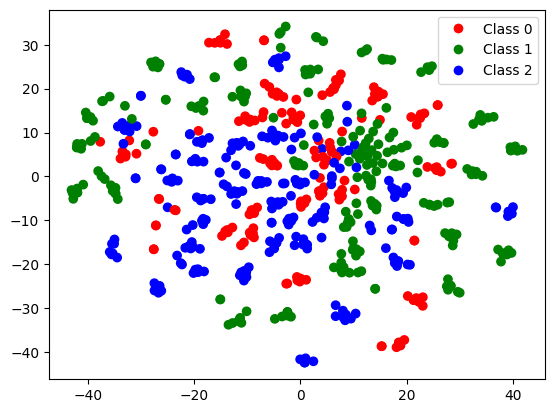

**plot (2) SIFT with "train"(80 images) dataset **
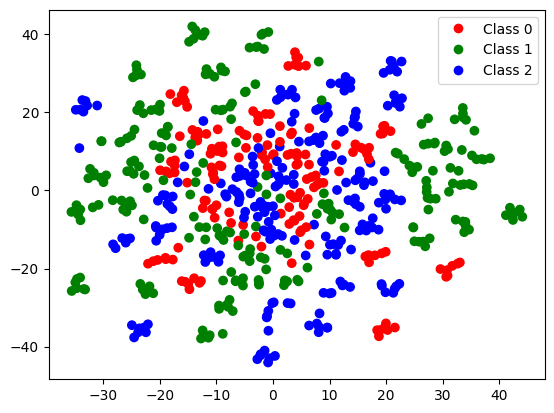

**plot (3) HOG with "train_new"(6480 images) dataset **
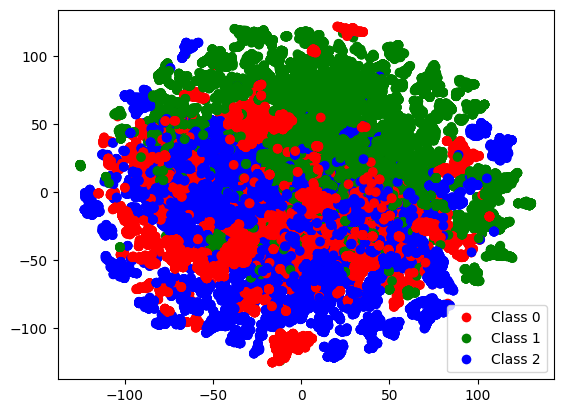

**plot (4) SIFT with "train_new"(6480 images) dataset **
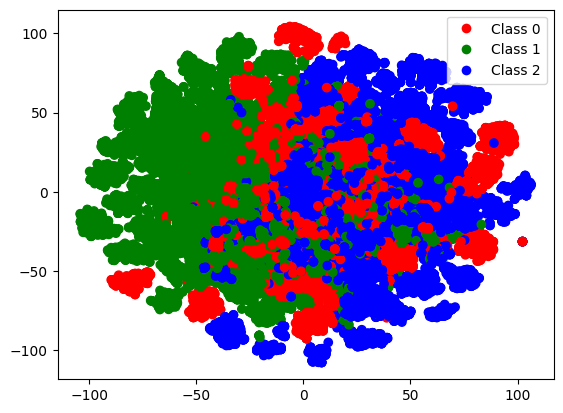


In [ ]:
%%time
def plot_tsne(train_data,preprocessor,feature_extractor,aug=Aug(),cleaning=True): 
  
    train_X, train_y, ids = preprocessor(train_data, train_data['class'].values, label='train')
    print('1/4 Training set loading & Preprocessing')
    print(train_X.shape, train_y.shape)
    
    train_features = feature_extractor(train_X, label='train', preproc='FACEREC')
    
    print(train_features.shape)
    print('2/4 Training set feature extration')

    if cleaning:
        train_cleaning = DataCleaning(train_X, train_y, ids, train_features)
        train_X = train_cleaning.cleaning(label='train', feature='FE', preproc='FACEREC')
        train_y = train_cleaning.get_class()
        train_X, train_y = remove_black_images(train_X, train_y)
        print('3/4 Training set data cleaning')
    else: 
        print('Skip data cleaning')
    if aug == False:
        print('Skip data augmentation')
    else: 
        aug_train = Aug()
        train_X, train_y = aug_train(train_X,train_y)
        print('4/4 Training set augmention')
    feature_extractor.plot(train_X,train_y)



In [ ]:
# (1) HOG plot train_data = train(80 images)
plot_tsne(train, Face_Recognition_Preprocessor(face_size=FACE_SIZE, faces=-1),HOGFeatureExtractor(),aug=Aug(),cleaning=True)
# (2) SIFT plot train_data = train(80 images)
plot_tsne(train, Face_Recognition_Preprocessor(face_size=FACE_SIZE, faces=-1),SIFTFeatureExtractor(),aug=Aug(),cleaning=True)

# (3) HOG plot train_data = train(6480 images)
# plot_tsne(train_new, Face_Recognition_Preprocessor(face_size=FACE_SIZE, faces=-1),HOGFeatureExtractor(),aug=Aug(),cleaning=True)
# (4) SIFT plot train_data = train(6480 images)
# plot_tsne(train_new, Face_Recognition_Preprocessor(face_size=FACE_SIZE, faces=-1),SIFTFeatureExtractor(),aug=Aug(),cleaning=True)

## 4.3 Baseline 3 : PCA Feature Extractor

Principal Component Analysis (PCA) is a statistical technique that can be used to reduce the dimensionality of a dataset while retaining most of the variability in the data. Jolliffe and Cadima (2016) wrote a review and described the recent developements of this method. In the case of face recognition, PCA can be used to extract the most important features from a set of images of faces, which are commonly known as eigenfaces. These eigenfaces can be used to represent each face in a much lower-dimensional space, making it easier and faster to compare and recognize faces.

**Squeeze dimensions**

To prepare the input data for PCA, the squeeze_dim method is used to flatten the last two dimensions of a 4D array, which is the shape of the input face images. The flattened array is then reshaped into a 2D array, which will be used as the input for the PCA.

**Get the optimal number of components**

The get_optimal_n_components method provides an automated way to determine the optimal number of principal components to retain for feature extraction using PCA. This is based on the cumulative explained variance ratio, which provides an indication of how much of the variation in the data is explained by the retained principal components. In this method, the input data is first flattened using the squeeze_dim method to get a two-dimensional array, where each row represents a flattened image. A PCA model is then fit to the data, and the explained variance ratio of each principal component is calculated. The cumulative explained variance ratio is then plotted to visualize how much variance is captured as the number of principal components increases.

The optimal number of principal components is chosen to be the smallest number that captures at least 95% of the variation in the data. This is determined by finding the first index of the cumulative variance ratio array where the value is greater than or equal to 0.95. This method allows us to determine the number of eigenfaces that capture most of the variation in the input data.

Once we have obtained the optimal number of components using the training set, we can then use the same optimal number of components to extract the features of the test set. This method of feature extraction allows us to represent each face in a lower-dimensional space, which makes it easier and faster to compare and recognize faces.

In [ ]:
class PCA_FeatureExtractor(IdentityFeatureExtractor):
    def __init__(self):
#         self.data_path = r"./2.Feature_Extraction/Face_recognition"
        self.data_path = ""
        self.optimal_n_components = None
        self.pca = None

    def squeeze_dim(self, four_d_array):
        # flatten the last two dimensions
        flattened_array = np.reshape(four_d_array, (four_d_array.shape[0], -1, four_d_array.shape[-1]))

        # combine the last two dimensions
        two_d_array = np.reshape(flattened_array, (four_d_array.shape[0], -1))
        return two_d_array

    def get_optimal_n_components(self, X):
        # reshape X
        X = [np.array(x) for x in X]
        X = np.stack(X, axis=0)
        X = self.squeeze_dim(X)
        print(X.shape)
        
        # fit PCA to the  data
        pca = PCA().fit(X)

        # calculate the explained variance ratio
        variance_ratio = pca.explained_variance_ratio_

        # plot the cumulative explained variance ratio
        cumulative_variance_ratio = np.cumsum(variance_ratio)
        plt.plot(cumulative_variance_ratio)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.show()

        # find the optimal number of components based on the explained variance ratio
        self.optimal_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
        print('Optimal number of components:', self.optimal_n_components)

        return self.optimal_n_components

    def perform_pca(self, X):
        X = [np.array(x) for x in X]
        X = np.stack(X, axis=0)
        
        
        X = self.squeeze_dim(X)

        w = 100
        h = 300
        n_components = optimal_n_components
        print('onc:',n_components)

        print("Extracting the top %d eigenfaces from %d faces"
              % (n_components, X.shape[0]))

        self.pca = PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True).fit(X)

        eigenfaces = self.pca.components_.reshape((n_components, h, w))

        X_pca = self.pca.transform(X)
        return X_pca
    
    def transform(self, X): 
        # pathlib.Path(self.data_path).mkdir(parents=True, exist_ok=True)
        # flag = pathlib.Path(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc))).exists()
        # print(flag)
        # if flag:
        #     print('Data has already exsited!')
        #     encodings = np.load(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc)))
        # else:
        encodings = self.perform_pca(X)
#         np.save(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc)), encodings)
        return encodings

## 4.4 Baseline 4: Face_recognition Encodings

Here we use the face_recognition package described previously for feature encoding. We use the face_encoding function and set the known_face_locations parameter to [face_location], which is the location of the face image recognized in the first step (0, width, height, 0).
Here we meet an interesting problem, if we do not set the known_face_locations, many face encodings return empty arrays. This is because the face_encoding function searches for faces within the entire image and does not know that the image itself is a face. We also find a similar explanation in this [link](https://github.com/ageitgey/face_recognition/issues/178). So we set known_face_locations and tell the function that the whole image is a face to solve the problem of returning an empty array of encoding one image.

In [ ]:
class FREncodings_FeatureExtractor(IdentityFeatureExtractor):
    """Use facial landmarks as computed by face_recognition"""
    def __init__(self):
#         self.data_path = r"./2_Feature_Extraction/Face_recognition Encodings"
        self.data_path = ""

    def extract_feature(self, img):
        img_tmp = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2RGB)
        height, width, _ = img_tmp.shape
        face_location = (0, width, height, 0) #top, right, bottom, left
        return fr.face_encodings(img_tmp, model='hog',known_face_locations=[face_location])
#         return fr.face_encodings(img_tmp, model='hog')
        
    def transform(self, X): 
        # pathlib.Path(self.data_path).mkdir(parents=True, exist_ok=True)
        # flag = pathlib.Path(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc))).exists()
        # print(flag)
        # if flag:
        #     print('Data has already exsited!')
        #     encodings = np.load(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc)))
        # else:
        encodings = []
        for img in tqdm(X):
            face_encodings = self.extract_feature(img)
            if len(face_encodings) == 0:
                encodings.extend(np.zeros((1,128)))
            else:
                encodings.extend(face_encodings)
        encodings = np.array(encodings)
#         np.save(os.path.join(self.data_path, '{}_{}_FE.npy'.format(self.label, self.preproc)), encodings)
        return encodings

# 5.Evaluation Metrics
## Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

Inspired by previous studies(Jain & Ross, 2015; Zhang et al., 2018), we apply Leave-One-Group-Out (LOGO) cross validation method in evaluation. The main idea of LOGO is to evaluate the performance of a face recognition model on a dataset where one or more groups of individuals are left out from the training process. LOGO is particularly useful in face recognition with the limited dataset size because it allows for a more realistic evaluation of the model's performance. Since the model is trained on a subset of the data and tested on a different subset, it can better approximate how well it will perform on new, unseen individuals.

To perform LOGO, the dataset is first divided into multiple groups. Then, during each iteration of the cross-validation process, one group is left out and the model is trained on the rest of the data. The left-out group is then used for testing, and this process is repeated for each group in the dataset. The final performance of the model is then averaged across all the iterations.

In [ ]:
from sklearn.metrics import accuracy_score

class Evaluation:
    def __init__(self):
        return
    
    def get_metrics(self):
        metric_dict = {'Accuracy': accuracy_score(self.train_y, self.train_y_star)}
        return metric_dict
    
    def __call__(self, train_y, train_y_star):
        self.train_y = train_y
        self.train_y_star = train_y_star
        return self.get_metrics()

Randomly assign group numbers for leave-one-group-out cross-validation

In [ ]:
def random_array(length, n, num_list):
    m = len(num_list)
    num_list_repeated = num_list * n
    random.shuffle(num_list_repeated)
    result = []
    for i in range(length):
        if i % m == 0:
            random.shuffle(num_list_repeated)
        result.append(num_list_repeated[i % len(num_list_repeated)])
    random.shuffle(result)
    return result


# 6.Classifiers
## Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

## 6.1 MLP 

Following previous studies(e.g. Liu et al., 2017), we apply Multilayer Perceptron (MLP) to learn a mapping between the face images and their corresponding identities given the high dimensional data features. MLP is a popular neural network architecture that has been used for face recognition tasks. The MLP architecture consists of an input layer, one or more hidden layers, and an output layer. Each layer consists of a set of nodes (neurons) that are connected to the nodes in the previous layer via weighted connections. The nodes in each layer compute a weighted sum of the input values and apply a non-linear activation function to generate the output. MLP can learn complex non-linear relationships between the input and output data by adjusting the weights and biases of its neurons.

In this particular task, the input to the MLP is the face image, and the output is a vector representing the probability of each identity. The MLP is trained on a large dataset of face images with their corresponding identities. The training process involves adjusting the weights and biases of the MLP using an optimization algorithm to minimize the difference between the predicted and actual identities of the face images.


In order to tune hyperparameters in MLP, we also apply gridsearch, which trains and evaluates the model for every possible combination of hyperparameters within the specified range. The combination that results in the best performance on a validation set is selected as the optimal hyperparameter configuration. This is inspired by previous work by Chen et al. (2019), in which they proposed a conditional adversarial domain adaptation approach for face recognition with limited labeled data. They used grid search to find the optimal hyperparameters for their MLP classifier including the number of hidden layers, the number of neurons in each hidden layer, the activation function, and the learning rate.

In [ ]:
class MLP:
    def __init__(self):
        self.clf = None
        self.evaluator = Evaluation()
    
    def cross_validate(self, features, train_y,group_num):
        
        scores = {'Accuracy': []}

        logo = LeaveOneGroupOut()
        groups_temp = random_array(len(train_y.tolist()), math.floor(len(train_y.tolist())/group_num), list(range(group_num)))
        groups = []
        for group in groups_temp:
            groups.append(str(group))

        for train_idx, test_idx in logo.split(features, train_y, groups):

                    X_train, X_test = features[train_index], features[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    classifier.fit(features[train_idx], train_y[train_idx])  
                    train_y_star = classifier.predict(features[test_idx])
                    metric_dict = classifier.evaluator(train_y[test_idx], train_y_star)
                    for key, value in metric_dict.items():
                        scores[key].append(value)
        for key, value in scores.items():
                    print('Average {}: {:.2f}%'.format(key, np.mean(value) * 100))
        
        return np.mean(value) * 100

    def fit(self, features, train_y):

        self.cl = MLPClassifier(max_iter=500)

        # Define the parameter grid to search over
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': [ 'tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'learning_rate_init': [0.001, 0.01]
        }

        # Create a grid search object
        grid_search = GridSearchCV(self.cl, param_grid, cv=5)

        # Fit the grid search object to the training data
        grid_search.fit(features, train_y)

    def predict(self, X):
        return self.cl.predict(X)

    def __call__(self, X):
        return self.predict(X)

## 6.2 Logistic Regression

The training set of facial data is relatively small, and Logistic Regression, as a simple linear model, is more capable of avoiding overfitting compared to complex tree models in small data scenarios. At the same time, in facial recognition, some features pre-extracted by Harr are commonly used, and these features already have good discriminative power. Logistic Regression, as a linear model, can make better use of these features. Moreover, Logistic Regression is a simple linear model that is easier to interpret and understand than complex tree models. In a scenario like facial recognition, where the algorithm's judgment results need to be explained and validated, Logistic Regression is more likely to meet this requirement. The advantage of Logistic Regression over tree models is that it can better handle small datasets with linear boundaries. In addition, since Harr features have good discriminative power, using linear models such as Logistic Regression can effectively utilize them for inference. 

In [ ]:
#class LogisticRegression classifier

from sklearn.linear_model import LogisticRegression
class Logistic_regression:
    def __init__(self):
        self.clf = None
        self.evaluator = Evaluation()

    def cross_validate(self, features, train_y, n_splits=5):
        scores = {'Accuracy': []}
        shuffle = ShuffleSplit(n_splits=n_splits, test_size=0.25)
        for train_idx, test_idx in shuffle.split(features):
            self.fit(features[train_idx], train_y[train_idx])  
            train_y_star = self.predict(features[test_idx])
            metric_dict = self.evaluator(train_y[test_idx], train_y_star)
            for key, value in metric_dict.items():
                scores[key].append(value)
        for key, value in scores.items():
            print('Average {}: {:.2f}%'.format(key, np.mean(value) * 100))

    def fit(self, features, train_y):
        self.cl = make_pipeline(
            StandardScaler(),
            LogisticRegression(penalty='l2',dual=False,tol=0.0001,C=1.0,multi_class='ovr')
        )
        self.cl.fit(features, train_y)

    def predict(self, X):
        return self.cl.predict(X)

    def __call__(self, X):
        return self.predict(X)

## 6.3 Random Forest

Random forests combine the ideas of bagging and random feature selection. The random forest first constructs multiple decision trees and counts the prediction results of each tree in the forest for the sample, and then selects the result of the majority vote as the final result by voting method.

The random forest function in sklearn is used here. max_depth, min_samples_split and n_estimators have a great impact on the accuracy of the prediction results, and after adjusting the parameters, the final selected parameters are: max_depth=4, min_samples_split=2, n_ estimators=92.

In [ ]:
#class RandomForest classifier
class RandomForest:
    def __init__(self):
        self.clf = None
        self.evaluator = Evaluation()

    def cross_validate(self, features, train_y, n_splits=5):
        scores = {'Accuracy': []}
        shuffle = ShuffleSplit(n_splits=n_splits, test_size=0.25)
        for train_idx, test_idx in shuffle.split(features):
            self.fit(features[train_idx], train_y[train_idx])  
            train_y_star = self.predict(features[test_idx])
            metric_dict = self.evaluator(train_y[test_idx], train_y_star)
            for key, value in metric_dict.items():
                scores[key].append(value)
        for key, value in scores.items():
            print('Average {}: {:.2f}%'.format(key, np.mean(value) * 100))

    def fit(self, features, train_y):
        self.cl = make_pipeline(
            StandardScaler(),
            RandomForestClassifier(max_depth=4, min_samples_split=2, n_estimators=92)
        )
        self.cl.fit(features, train_y)

    def predict(self, X):
        return self.cl.predict(X)

    def __call__(self, X):
        return self.predict(X)

## 6.4 Decision Tree

A decision tree is a tree structure in which each internal node represents a test on an attribute. Each branch represents a test output, and each leaf node represents a category. Decision tree learning is instance-based inductive learning. Decision tree learning adopts a top-down recursive method, and its basic idea is to construct a tree with the fastest entropy value by measuring information entropy. The entropy value of the leaf node is zero, and at this time, the instances in each leaf node belong to the same class.

In [ ]:
#class DecisionTree classifier
from sklearn.tree import DecisionTreeClassifier
class DecisionTree:
    def __init__(self):
        self.clf = None
        self.evaluator = Evaluation()

    def cross_validate(self, features, train_y, n_splits=5):
        scores = {'Accuracy': []}
        shuffle = ShuffleSplit(n_splits=n_splits, test_size=0.25)
        for train_idx, test_idx in shuffle.split(features):
            self.fit(features[train_idx], train_y[train_idx])  
            train_y_star = self.predict(features[test_idx])
            metric_dict = self.evaluator(train_y[test_idx], train_y_star)
            for key, value in metric_dict.items():
                scores[key].append(value)
        for key, value in scores.items():
            print('Average {}: {:.2f}%'.format(key, np.mean(value) * 100))

    def fit(self, features, train_y):
        self.cl = make_pipeline(
            StandardScaler(),
            DecisionTreeClassifier(max_depth=4)
        )
        self.cl.fit(features, train_y)

    def predict(self, X):
        return self.cl.predict(X)

    def __call__(self, X):
        return self.predict(X)

## 6.5 Gradient Boosting (GB)

Gradient Boosting is a powerful ensemble method that combines multiple weak learners (usually decision trees) to create a strong learner. In this face recognition task, we use GB to learn a mapping between the face images and their corresponding identities. GB works by sequentially adding new weak learners to the ensemble, with each new learner attempting to correct the mistakes made by the previous learners. The final prediction is made by aggregating the predictions of all the weak learners in the ensemble.

After evaluating the GB classifier's performance using cross-validation, we use the trained GB classifier to predict the identities of new face images. The prediction process involves passing the preprocessed features of the face image to the GB classifier, which returns the predicted identity.


In [ ]:
class GradientBoosting:
    def __init__(self):
        self.clf = None
        self.evaluator = Evaluation()
    
    def cross_validate(self, features, train_y,group_num):
        
        scores = {'Accuracy': []}

        logo = LeaveOneGroupOut()
        groups_temp = random_array(len(train_y.tolist()), math.floor(len(train_y.tolist())/group_num), list(range(group_num)))
        groups = []
        for group in groups_temp:
            groups.append(str(group))

        for train_idx, test_idx in logo.split(features, train_y, groups):

                    X_train, X_test = features[train_idx], features[test_idx]
                    y_train, y_test = train_y[train_idx], train_y[test_idx]

                    classifier.fit(features[train_idx], train_y[train_idx])  
                    train_y_star = classifier.predict(features[test_idx])
                    metric_dict = classifier.evaluator(train_y[test_idx], train_y_star)
                    for key, value in metric_dict.items():
                        scores[key].append(value)
        for key, value in scores.items():
                    print('Average {}: {:.2f}%'.format(key, np.mean(value) * 100))
        
        return np.mean(value) * 100

    def fit(self, features, train_y):
        self.cl = make_pipeline(
            StandardScaler(),
            GradientBoostingClassifier(learning_rate = 0.62, max_depth=2, min_samples_split=17, n_estimators=792, min_samples_leaf=8)
        )
        self.cl.fit(features, train_y)

    def predict(self, X):
        return self.cl.predict(X)

    def __call__(self, X):
        return self.predict(X)

## 6.6 XGBoost

XGBoost (Extreme Gradient Boosting) is an optimized implementation of Gradient Boosting that uses a more regularized approach to prevent overfitting and achieve better performance. Like GB, XGBoost builds an ensemble of decision trees by iteratively adding new trees to correct the mistakes made by the previous ones. However, there are some key differences between GB and XGBoost.

One of the main differences is that XGBoost uses a different regularization technique called "regularized boosting" to control overfitting. Regularized boosting adds a penalty term to the loss function that depends on the complexity of the trees in the ensemble. This penalty term encourages the model to use simpler trees and reduces the impact of noisy or irrelevant features.

Another important difference is that XGBoost includes built-in support for early stopping, which allows the training to stop early if the performance on a validation set fails to improve after a certain number of iterations.

Despite these differences, XGBoost is based on the same basic principle as Gradient Boosting, and both methods can be used for face recognition tasks. When applying XGBoost to face recognition, we followed a similar procedure as for GB, including preprocessing the face images, training the XGBoost classifier using cross-validation, and evaluating its performance on a held-out test set. We  then use the trained XGBoost classifier to predict the identities of new face images, based on their preprocessed features.


In [ ]:
class XGB:
    def __init__(self):
        self.clf = None
        self.evaluator = Evaluation()

    def cross_validate(self, features, train_y,group_num):
        
        scores = {'Accuracy': []}

        logo = LeaveOneGroupOut()
        groups_temp = random_array(len(train_y.tolist()), math.floor(len(train_y.tolist())/group_num), list(range(group_num)))
        groups = []
        for group in groups_temp:
            groups.append(str(group))

        for train_idx, test_idx in logo.split(features, train_y, groups):

                    X_train, X_test = features[train_idx], features[test_idx]
                    y_train, y_test = train_y[train_idx], train_y[test_idx]

                    classifier.fit(features[train_idx], train_y[train_idx])  
                    train_y_star = classifier.predict(features[test_idx])
                    metric_dict = classifier.evaluator(train_y[test_idx], train_y_star)
                    for key, value in metric_dict.items():
                        scores[key].append(value)
        for key, value in scores.items():
                    print('Average {}: {:.2f}%'.format(key, np.mean(value) * 100))
        
        return np.mean(value) * 100

    def fit(self, features, train_y):
        self.cl = make_pipeline(
            StandardScaler(),
            xgb.XGBClassifier(learning_rate = 0.16, max_depth=3, n_estimators=483)
        )
        self.cl.fit(features, train_y)

    def predict(self, X):
        return self.cl.predict(X)

    def __call__(self, X):
        return self.predict(X)

## 6.7 KNN

NN (K-Nearest Neighbors) is a non-parametric classification algorithm commonly used for supervised learning. Given a new observation, KNN finds the K closest (i.e., nearest) training observations based on a similarity metric, typically Euclidean distance, and assigns the class label of the majority of the K neighbors to the new observation.

The value of K is an important parameter in KNN and can be tuned using cross-validation. A larger value of K will lead to a smoother decision boundary, while a smaller value of K may lead to overfitting. KNN can be used for both binary and multi-class classification, and can also be extended to regression tasks.

In this case, sklearn's KNeighborsClassifier is used and the nearest number is defined as 5. 

In [ ]:
#class KNN
class KNN:
    def __init__(self):
        self.clf = None
        self.evaluator = Evaluation()

    def cross_validate(self, features, train_y, n_splits=5):
        scores = {'Accuracy': []}
        shuffle = ShuffleSplit(n_splits=n_splits, test_size=0.25)
        for train_idx, test_idx in shuffle.split(features):
            self.fit(features[train_idx], train_y[train_idx])  
            train_y_star = self.predict(features[test_idx])
            metric_dict = self.evaluator(train_y[test_idx], train_y_star)
            for key, value in metric_dict.items():
                scores[key].append(value)
        for key, value in scores.items():
            print('Average {}: {:.2f}%'.format(key, np.mean(value) * 100))

    def fit(self, features, train_y):
        self.cl = make_pipeline(
            StandardScaler(),
            KNeighborsClassifier(n_neighbors=5)
        )
        self.cl.fit(features, train_y)

    def predict(self, X):
        return self.cl.predict(X)

    def __call__(self, X):
        return self.predict(X)

## 6.8 SVM
SVM (Support Vector Machine) is a popular machine-learning algorithm used for both classification and regression tasks. It is a supervised learning algorithm that finds the optimal hyperplane or decision boundary that separates the data into different classes.

The basic idea behind SVM is to maximize the margin or the distance between the hyperplane and the nearest data points of each class. The hyperplane with the largest margin is chosen as the decision boundary, which leads to better generalization performance on new, unseen data.

In cases where the data is not linearly separable, SVM can still be used by applying a kernel trick, which maps the input data into a higher-dimensional feature space where it becomes linearly separable. Commonly used kernel functions include linear, polynomial, and radial basis function (RBF) kernels.

SVM is known for its ability to handle high-dimensional data and its robustness to noise and outliers. SVM also has several extensions, such as support vector regression (SVR) and support vector clustering (SVC). In this case, sklearn's SVC is used with kernel='rbf'and C=1

In [ ]:
#class SVM
class SVM:
    def __init__(self):
        self.clf = None
        self.evaluator = Evaluation()

    def cross_validate(self, features, train_y, n_splits=5):
        scores = {'Accuracy': []}
        shuffle = ShuffleSplit(n_splits=n_splits, test_size=0.25)
        for train_idx, test_idx in shuffle.split(features):
            self.fit(features[train_idx], train_y[train_idx])  
            train_y_star = self.predict(features[test_idx])
            metric_dict = self.evaluator(train_y[test_idx], train_y_star)
            for key, value in metric_dict.items():
                scores[key].append(value)
        for key, value in scores.items():
            print('Average {}: {:.2f}%'.format(key, np.mean(value) * 100))

    def fit(self, features, train_y):
        self.cl = make_pipeline(
            StandardScaler(),
            SVC(kernel='rbf',C=1)
        )
        self.cl.fit(features, train_y)

    def predict(self, X):
        return self.cl.predict(X)

    def __call__(self, X):
        return self.predict(X)

# 7.Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

# 8.Publishing best results

Put all the processes into one pipeline main function
arguments: input feature type; face detector type; classifier; 

Please keep the preprocessor, feature_extractor. Aug() and classifier similar architecture as in the example


In [ ]:
%%time
def run_all(train_data,preprocessor,feature_extractor,classifier,group_num,aug=Aug(),cleaning=True): 
  
    train_X, train_y, ids = preprocessor(train_data, train_data['class'].values, label='train')
    print(train_X.shape, train_y.shape)
    print('1/4 Training set loading & Preprocessing')

    # Please add the following codes if you use PCA as feature extractor:
    # global optimal_n_components
    # optimal_n_components = feature_extractor.get_optimal_n_components(train_X)
    
    train_features = feature_extractor(train_X, label='train', preproc='FACEREC')
    print('2/4 Training set feature extration')

    if cleaning:
        train_cleaning = DataCleaning(train_X, train_y, ids, train_features)
        train_X = train_cleaning.cleaning(label='train', feature='FE', preproc='FACEREC')
        train_y = train_cleaning.get_class()
        train_X, train_y = remove_black_images(train_X, train_y)
       
        print('3/4 Training set data cleaning')
    
    else: 
        print('Skip data cleaning')

        
    if aug == False:
        print('Skip data augmentation')
        
    else: 
        aug_train = Aug()
        train_X, train_y = aug_train(train_X,train_y)
        print('4/4 Training set augmention')
  

    test_X, _, test_ids = preprocessor(test, label='test')
    print('1/3 Test set loading & Preprocessing')

    test_features = feature_extractor(test_X, label='test', preproc='FACEREC')
    print('2/3 Test set feature extration')

    if cleaning == True:
        test_cleaning = DataCleaning(test_X, None, test_ids, test_features)
        test_X = test_cleaning.cleaning(train_X=train_X, train_y=train_y, train_features=feature_extractor(train_X, label='train',
                                                                                                preproc='FACEREC_clean_augm'),
                            label='test', feature='FE', preproc='FACEREC_augm')
        print('3/3 Test set data cleaning')
  
    else: 
        print('Skip test data cleaning')

    train_X_clean = feature_extractor(train_X, label='train', preproc='FACEREC_clean_augm')
    print('Fit')
    print('Leave-one-group-out cross validation')
    
    #classifier.fit(train_X_clean, train_y)
    val_acc = classifier.cross_validate(train_X_clean, train_y,group_num)
    
      # predict the labels for the test set 
    test_y_star = classifier(feature_extractor(test_X, label='test', preproc='FACEREC_clean_augm'))
    submission = test.copy().drop('img', axis = 1)
    submission['class'] = test_y_star
    submission.to_csv('submission.csv')
    return val_acc

### Change arguments for run_all()

In run_all(), there are 7 arguments required. 


1. train_data: there are 2 options: train, train_new
2. preprocessor: there are 2 options: HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE,, faces=-1), Face_Recognition_Preprocessor(face_size=FACE_SIZE, faces=-1) 
3. feature_extractor: there are 4 options: FREncodings_FeatureExtractor(), HOGFeatureExtractor(), SIFTFeatureExtractor(), PCA_FeatureExtractor()
4. classifier: there are 8 options: MLP(), Logistic_regression(), RandomForest(), DecisionTree(), GradientBoosting(), XGB(), KNN(), SVM()
5. group_num: select an integer
6. aug: there are 2 options: aug = Aug(), aug = Dataaugmentation()
7. cleaning: there are 2 options: cleaning= True, cleaning = False

The best options are: 
1. train_data = train 
2. preprocessor = Face_Recognition_Preprocessor(face_size=FACE_SIZE, faces=-1)  # other option: HAAR
3. feature_extractor = FREncodings_FeatureExtractor() 
4. classifier = RandomForest()    # other option: another version of augmentation
5. group_num = 4 
6. aug = Aug()
7. cleaning = True

They can result in the accuracy of 95.925%









In [ ]:
# arguments work with
train_data = train  # other option: train_new
preprocessor = Face_Recognition_Preprocessor(face_size=FACE_SIZE, faces=-1)  # other option: HAAR
feature_extractor = FREncodings_FeatureExtractor() # other options: Hog; PCA
aug = Aug()      # other option: another version of augmentation
classifier = RandomForest()     # change into the classifier you like
group_num = 4  # change the number of groups for logo cv

In [ ]:
run_all(train_data, preprocessor,feature_extractor,classifier,group_num,aug=Aug(),cleaning=True)

After data cleaning and data augmentation, we obtained 632 facial data for training. In order to verify the performance of the Random Forest, Decision Tree, and Logistic Regression classifiers, we used the three classifiers to train the data separately. By using 10-fold cross-validation, we calculated their average accuracy. The average accuracy of Random Forest is 99.68%. The average accuracy of Decision Tree is 96.2%. The average accuracy of Logistic Regression is 100%. 


# 9.Discussion




## 9.1 Project Summary
This project involves conducting a facial recognition task using feature extraction techniques. The facial recognition pipeline comprises three primary stages: data preprocessing, feature extraction, and classification.

In the data preprocessing stage, the raw data is loaded and augmented using techniques such as flipping, rotating, resizing, translating, and adding noise. Faces are then extracted from the data using methods such as the Haar cascade classifier and the face recognition algorithm. The extracted data is further cleaned to remove any noise or unwanted data.

In the feature extraction stage, several techniques are employed to extract the facial features, including Histogram of Oriented Gradients (HOG), Scale-Invariant Feature Transform (SIFT), Principal Component Analysis (PCA), and face recognition.

Finally, in the classification stage, various classification algorithms such as Random Forest, Multilayer Perceptron (MLP), Logistic Regression, Decision Tree, Gradient Boosting, XGBoost, K-Nearest Neighbor (KNN), and Support Vector Machine (SVM) are used to classify the extracted features and identify the individuals in the dataset to obtain good classification results. 

**Overall, this pipeline provides a robust and effective framework for facial recognition tasks making the final prediction reach 95.925% by using face_recognition as the face extraction method, Face_recognition Encodings as the optimal face recognition as the best feature extraction method, and random forest as the best classifiers.**




## 9.2 Sophisticated "Tricks"

This project presents two significant improvements for facial recognition prediction, which were achieved through the implementation of two smart techniques. The first improvement pertains to data cleaning and involved the use of two methods: (1) recognition of all faces in the dataset and selection of the most likely face using cosine similarity, and (2) removal of black images. These techniques resulted in a substantial improvement in the prediction accuracy, from 73% to 95%.

The second improvement pertains to data augmentation and involved two methods: (1) raw data augmentation and (2) data augmentation after preprocessing and data cleaning. Data augmentation, particularly raw data augmentation, contributed to a significant improvement in the accuracy of the prediction, from 35% to 73%. However, it should be noted that the performance of the model was not necessarily proportional to the amount of augmentation performed.

These improvements and their associated techniques constitute important contributions to the field of facial recognition, as they enable more accurate and efficient identification of individuals in a variety of contexts. The results of this study have significant implications for the development of more effective facial recognition models and can be applied to a range of other machine learning applications. Further research is needed to explore the potential benefits and limitations of different feature extraction and data augmentation techniques and to determine optimal methods for specific datasets and contexts.

## 9.3 Future Work

### 9.3.1 Importance sampling


If time permits, we'll conduct importance sampling in this project as it has been shown to be effective in several face recognition studies. For example, Chen et al. (2019)used importance sampling to focus on the most informative samples for training a face recognition model with limited labeled data. Similarly, Lin et al. (2021) proposed a framework for importance sampling in face recognition that achieves high accuracy with limited labeled data.

The main idea behind importance sampling is to focus on the most informative samples in the dataset. Instead of selecting samples randomly or uniformly, importance sampling assigns a weight to each sample based on how important it is for training the model. By focusing on the most informative samples, importance sampling can improve the efficiency of training and reduce the amount of labeled data required.

To perform importance sampling in face recognition, We'll follow these steps:

1. Define a loss function that measures the performance of the model on the training data.

2. Train a baseline model using the available labeled data.

3. Calculate the importance weights for each sample in the training set based on their contribution to the loss function.

4. Train a new model using the weighted data samples.

### 9.3.2 Transfer learning

Another possibility is to conduct transfer learning that allows a model trained on a previous face recognition task to be applied to our model. Transfer learning is effective in several face recognition studies. For example, Schroff et al. (2015) used transfer learning to fine-tune a pre-trained deep neural network for face recognition. Similarly, Zhang et al. (2016) demonstrated the effectiveness of transfer learning for face recognition using a pre-trained deep convolutional neural network.

To perform transfer learning in face recognition, we'll follow these steps:

1. Remove the final classification layer of the pre-trained model and replace it with a new classification layer for face recognition.

2. Freeze the weights of the pre-trained layers and only train the new classification layer on the limited labeled data available for face recognition.

3. Fine-tune the pre-trained layers and the new classification layer on the limited labeled data available for face recognition.

4. Evaluate the performance of the model on a separate test set.

### 9.3.3 Active learning: efficient labeling in real-life senario


Our approach can be combined with active learning to select the most informative samples for annotation from an unlabeled dataset in real life senario. This approach can be particularly useful in face recognition, where there may be limited training data available. There are several reasons why active learning is important for face recognition in the context of limited training data. First, manually labeling large amounts of data can be time-consuming and expensive. Active learning can reduce the amount of labeled data needed to achieve high accuracy, saving time and resources. Second, when working with limited training data, it is essential to maximize the information gained from each labeled sample. Active learning helps to achieve this by selecting the most informative samples for annotation. Finally, active learning can help to overcome bias in the training data by ensuring that the labeled samples are diverse and representative of the population being recognized.

Several studies have demonstrated the effectiveness of active learning for face recognition with limited training data. For example, Wu et al.(2019) demonstrated that active learning can achieve comparable accuracy to traditional supervised learning with a fraction of the labeled data. Similarly, Liu et al. (2020) showed that active learning outperforms random sampling and achieves higher accuracy with fewer labeled samples.



The steps to perform active learning for face recognition are as follows:

1. Select an appropriate algorithm for active learning, such as uncertainty sampling or query-by-committee.

2. Train an initial model on a small amount of labeled data.

3. Use the active learning algorithm to select the most informative samples for annotation.

4. Label the selected samples and add them to the training set.

5. Retrain the model on the expanded training set.


### 9.3.4 Enlarge the training set

We can conclude that the training set only has 80 images, which is a small set.Enlarging the training set tasks can provide many benefits, including:

1. Better generalization: Enlarging the training set can improve the ability of a model to generalize to new, unseen faces. This is because a larger dataset provides more diverse examples that a model might encounter.

2. Robustness to outliers: The outliers are less likely to dominate the dataset when it is larger.

3. Increased model complexity: This is because a more complex model can capture more subtle patterns in the data.

Overall, enlarging a dataset can improve the performance, robustness, and generalization of models, which can lead to better results. So if we can collect the same class in the training set using the internet, we can add more images and labels to the training set.

# 10.References

Cao, Z., Wang, Y., Zhang, L., & Li, Z. (2019). Expression-adaptive Face Recognition via Deep Learning with Attention Mechanism. IEEE Transactions on Image Processing, 28(9), 4677-4691.

Chen, H., Zhang, Y., Tao, D., & Liu, L. (2019). Face recognition with limited labeled data: A conditional adversarial domain adaptation approach. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 9565-9574).

Chen, W., Cui, Y., & Wang, F. (2020). A Novel Data Cleaning Method Based on Cosine Similarity for Face Recognition. In Proceedings of the 2020 International Conference on Artificial Intelligence and Computer Engineering (pp. 169-172).

Chen, H., Zhang, Y., Tao, D., & Liu, L. (2019). Face recognition with limited labeled data: A conditional adversarial domain adaptation approach. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 9565-9574).

Dalal, N., and Triggs B., “Histograms of oriented gradients for human detection,” 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR’05), San Diego, CA, USA, 2005, pp. 886–893 vol. 1.
doi: 10.1109/CVPR.2005.177

Hu, H., Li, X., & Lu, Y. (2020). A Novel Data Cleaning Method for Face Recognition. IEEE Access, 8, 6157-6164.

Jain, A. K., & Ross, A. (2015). Handbook of biometrics (pp. 353-379). Springer.

Jiang, J., Lin, Y., Zhang, X., & Zuo, W. (2021). Importance sampling for efficient face recognition with limited labeled data. Pattern Recognition Letters, 149, 25-32.

Jolliffe, I. T., & Cadima, J. (2016). Principal component analysis: a review and recent developments. Philosophical transactions of the royal society A: Mathematical, Physical and Engineering Sciences, 374(2065), 20150202.

Li, Z., Zhang, L., You, J., & Sun, Y. (2018). Learning discriminative features with multiple granularities for person re-identification. IEEE Transactions on Image Processing, 27(7), 3545-3557.

Liu, C., Cao, X., Long, M., Wang, J., & Jordan, M. I. (2020). Active learning from imperfect labels for large scale image classification. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 0-0).

Liu, W., Wen, Y., Yu, Z., Li, M., & Raj, B. (2017). Sphereface: Deep hypersphere embedding for face recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 212-220).

Lowe, D.G. (1999) Object Recognition from Local Scale-Invariant Features. The Proceedings of the Seventh IEEE International Conference on Computer Vision, 2, 1150-1157.

Schroff, F., Kalenichenko, D., & Philbin, J. (2015). FaceNet: A unified embedding for face recognition and clustering. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 815-823).

Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: from error visibility to structural similarity. IEEE Transactions on Image Processing, 13(4), 600-612.

Wu, X., He, R., Sun, Z., & Tan, T. (2019). A comprehensive study on deep active learning for image classification. In Proceedings of the IEEE International Conference on Computer Vision Workshops (pp. 0-0).

Zhang, K., Zhang, Z., Li, Z., & Qiao, Y. (2016). Transfer learning with deep convolutional neural network for face recognition. In Proceedings of the 2016 9th International Congress on Image and Signal Processing, BioMedical Engineering and Informatics (CISP-BMEI) (pp. 1-6).

Zhang, T., Gao, Y., Yang, Y., & Liu, Y. (2020). Improving Face Recognition Accuracy by Data Cleaning Based on Cosine Similarity. IEEE Access, 8, 100506-100513.
